
=== Random Connected ===
Shadowing map generated.
Placed 10 nodes randomly.
Constructed random links: total links = 13


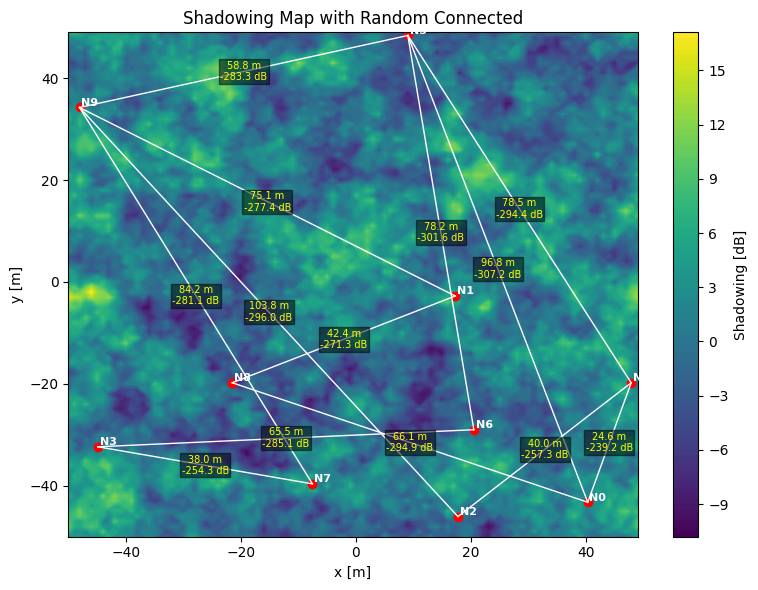

Shadowing stats: mean = 0.63 dB, std dev = 3.76 dB (target 4 dB)

=== Star Topology ===
Shadowing map generated.
Placed 10 nodes randomly.
Constructed star links: total links = 9


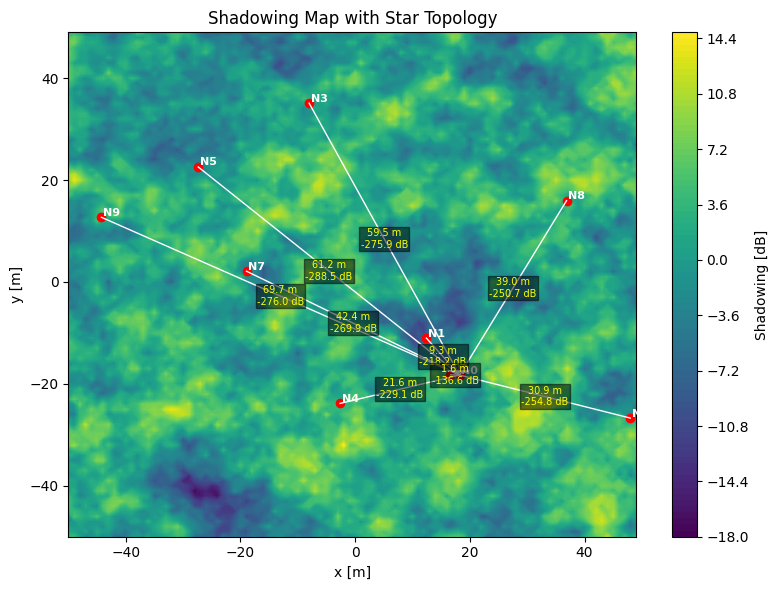

Shadowing stats: mean = 0.88 dB, std dev = 4.25 dB (target 4 dB)

=== Tree Topology ===
Shadowing map generated.
Placed 10 nodes randomly.
Constructed tree links: total links = 9


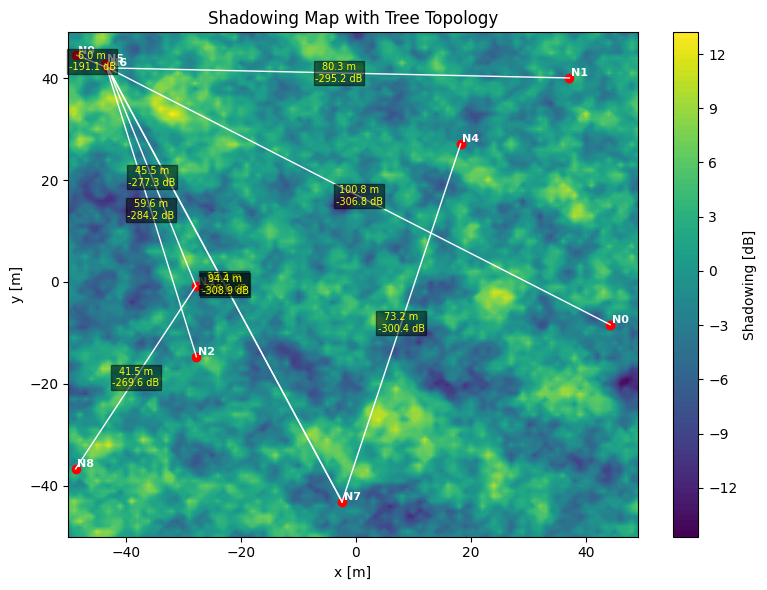

Shadowing stats: mean = -0.29 dB, std dev = 3.65 dB (target 4 dB)

=== Ring Topology ===
Shadowing map generated.
Placed 10 nodes randomly.
Constructed ring links: total links = 10


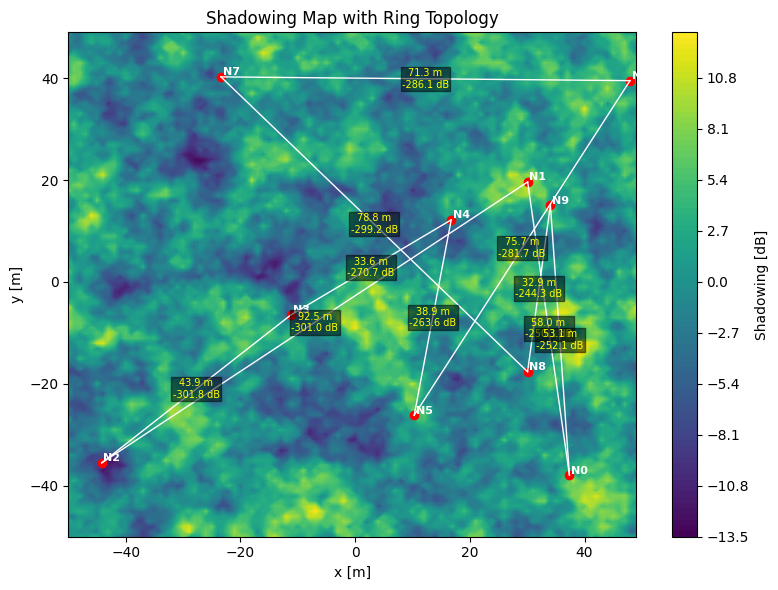

Shadowing stats: mean = 0.02 dB, std dev = 4.00 dB (target 4 dB)

=== Line Topology ===
Shadowing map generated.
Placed 10 nodes randomly.
Constructed line links: total links = 9


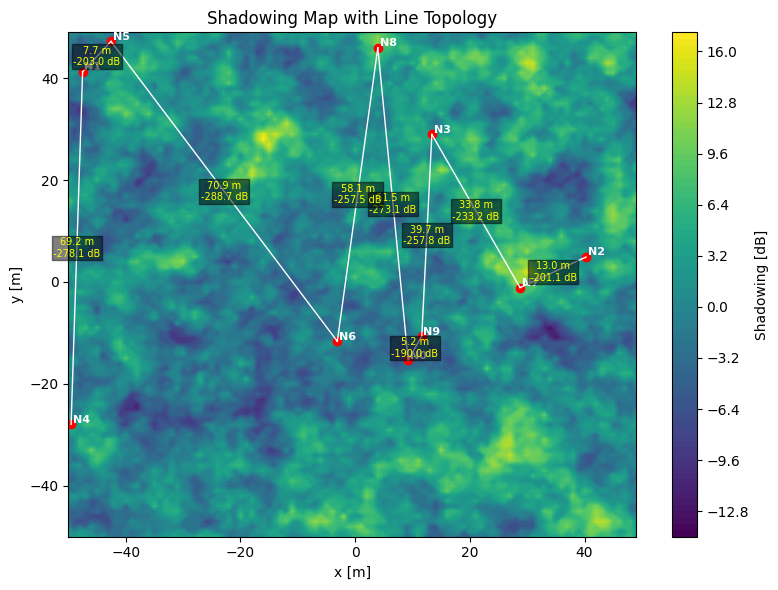

Shadowing stats: mean = 0.87 dB, std dev = 4.03 dB (target 4 dB)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# === Make imports work ===
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.insert(0, project_root)

from simulator.models.topology import DSpace, CartesianCoordinate, Topology
from simulator.models.ChannelModel import ChannelModel

# === Global RNG seed for reproducibility ===
np.random.seed(31)

# === Simulation parameters ===
dspace_step   = 1        # grid resolution [m]
dspace_npt    = 100      # 100×100 grid
freq          = 2.4e9    # signal frequency [Hz]
coh_d         = 5        # shadowing coherence distance [m]
shadow_dev    = 4        # shadowing σ [dB]
pl_exponent   = 3        # path-loss exponent
d0            = 1        # reference distance [m]
fading_shape  = 10.0     # Nakagami m
n_points      = 10       # number of nodes
link_prob     = 0.2      # probability of each extra link in random graph

# === Topology configurations ===
topo_configs = [
    {"name": "Random Connected", "type": "random"},
    {"name": "Star Topology",     "type": "star"},
    {"name": "Tree Topology",     "type": "tree"},
    {"name": "Ring Topology",     "type": "ring"},
    {"name": "Line Topology",     "type": "line"},
]

def build_topology(topo: Topology, ttype: str, rng: np.random.Generator):
    """Add links to 'topo' according to the requested type."""
    if ttype == "random":
        # ensure connectivity via a random spanning tree
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)
        # sprinkle extra random links
        for u in topo.node_ids:
            neigh = set(topo.get_neighbors(u))
            for v in topo.node_ids:
                if v > u and v not in neigh and rng.random() < link_prob:
                    topo.add_link(u, v)

    elif ttype == "star":
        # star: node 0 as center
        center = topo.node_ids[0]
        for other in topo.node_ids:
            if other != center:
                topo.add_link(center, other)

    elif ttype == "tree":
        # pure random spanning tree
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)

    elif ttype == "ring":
        # ring: connect each node to the next (and the last back to the first)
        ids = topo.node_ids
        for i in range(len(ids)):
            u, v = ids[i], ids[(i+1) % len(ids)]
            topo.add_link(u, v)

    elif ttype == "line":
        # line: sort by x-coordinate, then link sequentially
        sorted_nodes = sorted(
            topo.node_ids,
            key=lambda nid: topo.get_node_coordinate(nid).x
        )
        for i in range(len(sorted_nodes)-1):
            u, v = sorted_nodes[i], sorted_nodes[i+1]
            topo.add_link(u, v)

    else:
        raise ValueError(f"Unknown topology type: {ttype}")

# === Main loop over each configuration ===
rng = np.random.default_rng(31)
for cfg in topo_configs:
    name, ttype = cfg["name"], cfg["type"]
    print(f"\n=== {name} ===")

    # 1) Create discrete space and channel model
    dspace = DSpace(dspace_step=dspace_step, dspace_npt=dspace_npt)
    model  = ChannelModel(
        dspace=dspace,
        freq=freq,
        coh_d=coh_d,
        shadow_dev=shadow_dev,
        pl_exponent=pl_exponent,
        d0=d0,
        fading_shape=fading_shape
    )
    model.generate_shadowing_map()
    print("Shadowing map generated.")

    # 2) Build graph and add nodes at random positions
    topo = Topology()
    raw_pts = rng.uniform(-dspace._size/2, dspace._size/2, size=(n_points, 2))
    for idx, (x, y) in enumerate(raw_pts):
        coord = CartesianCoordinate(np.float64(x), np.float64(y))
        topo.add_node(node_id=idx, coordinate=coord)
    print(f"Placed {n_points} nodes randomly.")

    # 3) Add links per chosen topology
    build_topology(topo, ttype, rng)
    total_links = sum(len(topo.get_neighbors(n)) for n in topo.node_ids) // 2
    print(f"Constructed {ttype} links: total links = {total_links}")

    # 4) Plot shadowing map with contourf and overlay the topology
    fig, ax = plt.subplots(figsize=(8,6))
    cs = ax.contourf(
        dspace.X, dspace.Y,
        model.shadowing_map,
        levels=100,
        cmap='viridis'
    )
    ax.set_title(f"Shadowing Map with {name}")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

    # Plot nodes
    for node_id in topo.node_ids:
        P = topo.get_node_coordinate(node_id)
        ax.plot(P.x, P.y, 'ro')
        ax.text(P.x + 0.3, P.y + 0.3, f"N{node_id}", color='white',
                fontsize=8, weight='bold')

    # Plot links with annotations
    seen = set()
    for u in topo.node_ids:
        for v in topo.get_neighbors(u):
            if (v,u) in seen:
                continue
            seen.add((u,v))
            A = topo.get_node_coordinate(u)
            B = topo.get_node_coordinate(v)

            # draw line
            ax.plot([A.x, B.x], [A.y, B.y], 'w-', linewidth=1)

            # compute metrics
            distance = dspace.distance(A, B)
            loss_dB  = model.total_link_loss(A, B)

            # annotate at midpoint
            mx, my = (A.x + B.x)/2, (A.y + B.y)/2
            ax.text(
                mx, my,
                f"{distance:.1f} m\n{loss_dB:.1f} dB",
                color='yellow',
                fontsize=7,
                ha='center',
                va='center',
                bbox=dict(facecolor='black', alpha=0.5, pad=1)
            )

    fig.colorbar(cs, ax=ax, label='Shadowing [dB]')
    plt.tight_layout()
    plt.show()

    # 5) Print summary statistics
    mean_sh = model.shadowing_map.mean()
    std_sh  = model.shadowing_map.std()
    print(f"Shadowing stats: mean = {mean_sh:.2f} dB, std dev = {std_sh:.2f} dB "
          f"(target {shadow_dev} dB)")

